In [ ]:
%%writefile conf/config.yaml
# Arch	                        Start Lr	Max Steps	Decay Steps
# FullyConnectedArch	        1.00E-03	1500000	        15000	   
# FourierNetArch                1.00E-03	400000	        7500	   
# ModifiedFourierNetArch 	1.00E-03	400000	        7500	   
# SirenArch                     2.00E-05	500000	        5000	   
# DGMArch                       1.00E-03        1500000         15000           

# WARNING: Setting "exact_continuity" to true or setting the arch
# as "ModifiedFourierNetArch" increases the memory requirements of the 
# problem. Batchsizes may need to be reduced for such cases.  

defaults :
  - modulus_default
  - arch:
      - fully_connected
  - scheduler: exponential_lr 
  - optimizer: adam
  - loss: sum
  - _self_

jit: false


training:
  rec_results_freq : 100000
  rec_constraint_freq: 100000
  max_steps : 300000




    
    

In [3]:
%%writefile fhn3Ppred.py

from modulus.models.fully_connected import FullyConnectedArch
from modulus.models.fourier_net import FourierNetArch
from modulus.models.siren import SirenArch
from modulus.models.modified_fourier_net import ModifiedFourierNetArch
from modulus.models.dgm import DGMArch

from sympy import Symbol, Eq
from sympy import Symbol, Function, Number
from modulus.eq.pde import PDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import modulus
from modulus.hydra import instantiate_arch, ModulusConfig
from modulus.solver import Solver
from modulus.domain import Domain
from modulus.geometry.primitives_1d import Point1D
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from modulus.domain.validator import PointwiseValidator
from modulus.key import Key
from modulus.node import Node
from modulus.eq.pde import PDE
from modulus.geometry import Parameterization
from sympy import Symbol, Eq, Abs, tanh, Or, And
from modulus.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)
from modulus.solver import SequentialSolver

from modulus.models.deeponet import DeepONetArch
from modulus.domain.constraint.continuous import DeepONetConstraint
from modulus.models.moving_time_window import MovingTimeWindowArch
from modulus.domain.monitor import Monitor
from modulus.domain.constraint import Constraint
from modulus.graph import Graph
from modulus.key import Key
from modulus.constants import TF_SUMMARY
from modulus.distributed import DistributedManager
from modulus.utils.io import dict_to_csv, csv_to_dict
from modulus.domain.inferencer.pointwise import PointwiseInferencer as PointwiseInferencer
from modulus.loss.loss import CausalLossNorm

  
import os
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.cuda.profiler as profiler
import torch.distributed as dist
from termcolor import colored, cprint
from copy import copy
from operator import add
from omegaconf import DictConfig, OmegaConf
import hydra
import itertools
from collections import Counter
from typing import Dict, List, Optional
import logging
from contextlib import ExitStack
from typing import List, Union, Tuple, Callable


from modulus.domain.constraint import Constraint
from modulus.domain import Domain
from modulus.loss.aggregator import Sum
from modulus.utils.training.stop_criterion import StopCriterion
from modulus.constants import TF_SUMMARY, JIT_PYTORCH_VERSION
from modulus.hydra import (
    instantiate_optim,
    instantiate_sched,
    instantiate_agg,
    add_hydra_run_path,
)
from modulus.distributed.manager import DistributedManager
 

    
t_max = 50.0
n_w=1
t_w= t_max/n_w
BTZ=2000

def print_folder_contents(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return

    print(f"Contents of folder '{folder_path}':")
    for item in os.listdir(folder_path):
        print(item)

def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol

def generateValidator(i,nodes,data_folder="../.././validatiaon/"):
    # Read data arrays from CSV files
    
    print_folder_contents(data_folder)
    T = np.load(data_folder + "T.npy")
    K = np.load(data_folder + "K.npy")
    U = np.load(data_folder + "U.npy")
    V = np.load(data_folder + "V.npy")
    SOLs = np.load(data_folder + "SOLs.npy")
    SOLw = np.load(data_folder + "SOLw.npy")

    t = np.expand_dims(T, axis=-1)
    k = np.expand_dims(K, axis=-1)
    u = np.expand_dims(U, axis=-1)
    Solx = np.expand_dims(SOLs, axis=-1)
    Solw = np.expand_dims(SOLw, axis=-1)
    v = np.expand_dims(V, axis=-1)

    print("Added validation of shape", np.shape(Solx))
    invar_numpy = {
        "t": t,
        "K": k,
        "V": v,
        "U": u,
    }

    outvar_numpy = {
        "x1": Solx,
        "w":Solw
    }
    validator = PointwiseValidator(
        nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=1024,plotter=None
    )
    return validator



def generateDataC(i,nodes,data_folder="../.././treino1/"):
    # Read data arrays from CSV files
    
    print_folder_contents(data_folder)

    T = np.load(data_folder + "T.npy")
    K = np.load(data_folder + "K.npy")
    U = np.load(data_folder + "U.npy")
    V = np.load(data_folder + "V.npy")
    SOLs = np.load(data_folder + "SOLs.npy")
    SOLw = np.load(data_folder + "SOLw.npy")

    t = np.expand_dims(T, axis=-1)
    k = np.expand_dims(K, axis=-1)
    u = np.expand_dims(U, axis=-1)
    Solx = np.expand_dims(SOLs, axis=-1)
    Solw = np.expand_dims(SOLw, axis=-1)
    v = np.expand_dims(V, axis=-1)

    invar_numpy = {
        "t": t,
        "K": k,
        "V": v,
        "U": u,
    }
    print("Added data constraint of shape", np.shape(Solx))

    outvar_numpy = {
        "x1": Solx,
        "w":Solw
    }
    constraint = DeepONetConstraint.from_numpy(
        nodes=nodes,
        invar=invar_numpy,
        outvar=outvar_numpy,
        batch_size=BTZ,
        lambda_weighting=None
    )

    return constraint


class SpringMass(PDE):
    name = "SpringMass"

    def __init__(self):

        t = Symbol("t")
        K = Symbol("K")
       
        input_variables = {"t": t,"K":K}

        x = Function("x1")(*input_variables)
        w= Function("w")(*input_variables)
        self.equations = {}
        self.equations["ode_x1"] =10*(x*(x-0.4)*(1-x)-w+K) -x.diff(t)
        self.equations["ode_w"]  =0.2*(x*0.2-0.8*w) -w.diff(t)
        
@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:


    # make list of nodes to unroll graph on
    sm = SpringMass()
    sm.pprint()
    #sm_net = FullyConnectedArch(
    #    input_keys=[Key("t"), Key("K")],
    #    output_keys=[Key("x1")],
    #)
    #nodes = sm.make_nodes() + [
    #    sm_net.make_node(name="network")
    #]


    
    # make list of nodes to unroll graph on
    sm = SpringMass()
    sm.pprint()
    #sm_net = FullyConnectedArch(
    #    input_keys=[Key("t"), Key("K")],
    #    output_keys=[Key("x1")],
    #)
    #nodes = sm.make_nodes() + [
    #    sm_net.make_node(name="network")
    #]

    
    
    flow_net = FullyConnectedArch(
            input_keys=[Key("t"), Key("U"),Key("V"),Key("K") ],
            output_keys=[Key("x1"),Key("w")],
            layer_size=100,
            nr_layers=10,
        )

    

    #time_window_net = MovingTimeWindowArch(flow_net, t_w)

    nodes = sm.make_nodes() +[flow_net.make_node(name="network")]


    for node in nodes:
        print(node.__str__())
   
    # add constraints to solver
    # make geometry
    geo = Point1D(0)
    
    t_symbol = Symbol("t")
    x_symbol = Symbol("x1")
    k_symbol= Symbol("K")
    v_symbol= Symbol("V")
    u_symbol= Symbol("U")
    
    time_range = {t_symbol: (0,t_w )}
    k_range= {k_symbol:(0.08,0.012)}
    v_range= {v_symbol:(0,0.12)}
    u_range= {u_symbol:(0,1)}

    tr = {t_symbol: (0, t_w)}

    # make domain
        # make initial condition domain
    ic_domain = Domain("initial_conditions")

  
    # initial conditions
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": u_symbol,"w":v_symbol},
        batch_size=BTZ,
        parameterization={**{t_symbol:0},**k_range,**v_range,**u_range},
        lambda_weighting={
            "x1": 1000,# + 1000*x_symbol.diff(t_symbol)*x_symbol.diff(t_symbol),
            "w": 1000 #+ 1000*x_symbol.diff(t_symbol)*x_symbol.diff(t_symbol)
        },
        
        
        quasirandom=True,
    )

    ic_domain.add_constraint(IC, name="IC")
    
        # solve over given time period
    interior = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0,"ode_w":0.0},
        batch_size=BTZ,
        parameterization={**tr,**k_range,**v_range,**u_range},
        #criteria=And(t_symbol > 0, t_symbol < 3),
        lambda_weighting={
            "ode_x1": 100,# + 1000*x_symbol.diff(t_symbol)*x_symbol.diff(t_symbol),
            "ode_w":100 #+ 1000*x_symbol.diff(t_symbol)*x_symbol.diff(t_symbol)
        },
        quasirandom=True,
    )
    ic_domain.add_constraint(interior, name="interior")
    
    
       # solve over given time period
    interior2 = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0,"ode_w":0.0},
        batch_size=BTZ,
        parameterization={**tr,**{u_symbol:(0.45,0.65)},**{v_symbol:(0.0,0.12)},**k_range},
        #criteria=And(t_symbol > 0, t_symbol < 3),
        lambda_weighting={
            "ode_x1":100,# + 1000*x_symbol.diff(t_symbol)*x_symbol.diff(t_symbol),
            "ode_w": 100 #+ 1000*x_symbol.diff(t_symbol)*x_symbol.diff(t_symbol)
        },
        quasirandom=True,
    )
   #ic_domain.add_constraint(interior2, name="interiorTr")
    
    
    


    
 
    
    

    
    dom=[]
    dom.append((1,ic_domain))
    print(cfg)
    # make solver
    #slv = Solver(cfg, domain)
    #print(domains)
    i=0
    for a,d in dom:
      #  print(d)
      #  print(d.name)
        d.add_inferencer(generateValidator(i,nodes))
        d.add_validator(generateValidator(i,nodes))
        d.add_constraint(generateDataC(i,nodes,data_folder="../.././treino1/"),"data1")
        d.add_constraint(generateDataC(i,nodes,data_folder="../.././treino2/"),"data2")
        d.add_constraint(generateDataC(i,nodes,data_folder="../.././treino3/"),"data3")
       

        i=i+1
    
     
    slv = SequentialSolver(
        cfg,
        dom,

    )
    slv.solve()

        
        
        
if __name__ == "__main__":
    run()

Overwriting fhn3Ppred.py


In [ ]:
!rm -r outputs/fhn3Ppred
!python fhn3Ppred.py

[14:54:25] - JitManager: {'_enabled': False, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[14:54:25] - GraphManager: {'_func_arch': False, '_debug': False, '_func_arch_allow_partial_hessian': True}
ode_x1: 10*K + 10*(1 - x1)*(x1 - 0.4)*x1 - 10*w - x1__t
ode_w: -0.16*w + 0.04*x1 - w__t
ode_x1: 10*K + 10*(1 - x1)*(x1 - 0.4)*x1 - 10*w - x1__t
ode_w: -0.16*w + 0.04*x1 - w__t
node: Sympy Node: ode_x1
evaluate: SympyToTorch
inputs: [K, w, x1]
derivatives: [x1__t]
outputs: [ode_x1]
optimize: False
node: Sympy Node: ode_w
evaluate: SympyToTorch
inputs: [w, x1]
derivatives: [w__t]
outputs: [ode_w]
optimize: False
node: Arch Node: network
evaluate: FullyConnectedArch
inputs: [t, U, V, K]
derivatives: []
outputs: [x1, w]
optimize: True
{'training': {'max_steps': 1000000, 'grad_agg_freq': 1, 'rec_results_freq': 100000, 'rec_validation_freq': '${training.rec_results_freq}', 'rec_inference_freq': '${training.rec_results_freq}', 'rec_monitor_freq': '

overweriting


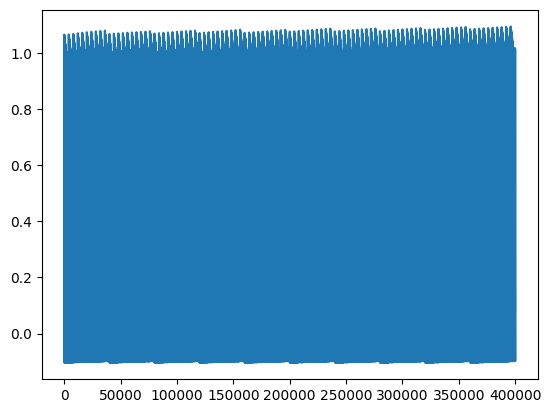

In [71]:
import numpy as np
import matplotlib.pyplot as plt
t_w=50
import os
def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol

def getConstraintFromData(w_i=1, data_folder="./treino1/"):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)
    SOLs = np.empty(0)
    SOLw = np.empty(0)
    V = np.empty(0)
    U = np.empty(0)
    krange = [(0.08 + 0.1 * i * 0.01) for i in range(0,10)]
    vrange = [(0 + 0.05 * i * 0.12) for i in range(0, 20)]
    urange = [(0 + 0.1 * i * 1) for i in range(0, 10)]

    deltaT = 0.01
    rate =25
    
    for UR in urange:
        for KR in krange:
            for VR in vrange:
                sol = generateExactSolution(t_w, deltaT, UR, VR, rate, KR, 0, t_w)

                T = np.append(T, sol.T[2] - 0)
                K = np.append(K, np.full_like(sol.T[2], KR))
                U = np.append(U, np.full_like(sol.T[2], UR))
                V = np.append(V, np.full_like(sol.T[2], VR))
                SOLs = np.append(SOLs, sol.T[0])
                SOLw = np.append(SOLw, sol.T[1])

    #print(SOLs)
    plt.plot(SOLs)
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
getConstraintFromData()


overweriting
(200000,)


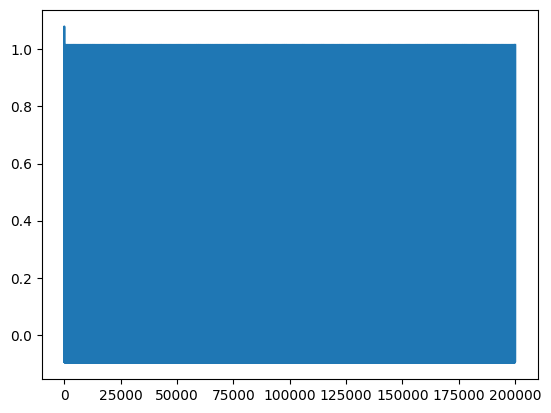

In [54]:
import numpy as np

t_max=50
def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol

def getConstraintFromData(w_i=1, data_folder="./treino2/"):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)
    SOLs = np.empty(0)
    SOLw = np.empty(0)
    U= np.empty(0)
    
    V = np.empty(0)
    u,v=0,0
    deltaT = 0.01
    rate = 25
    
    iap=0.09
    for i in range (1000):
                begin=0
                sol=generateExactSolution(t_max,deltaT,u,v,rate,iap,0,t_max)

                T=np.append(T,sol.T[2] - begin)
                K = np.append(K,np.full_like (sol.T[2],iap))
                U = np.append(U,np.full_like (sol.T[2],u))
 
                V= np.append(V,np.full_like(sol.T[2],v))

                SOLs=np.append(SOLs,sol.T[0])
                SOLw=np.append(SOLw,sol.T[1])
                u,v=SOLs[-1],SOLw[-1]
     

    print(np.shape(SOLs))
    plt.plot(SOLs)
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
    
getConstraintFromData()


[0.05       0.51348772 1.04939313 ... 0.77372351 0.77372249 0.77372087]


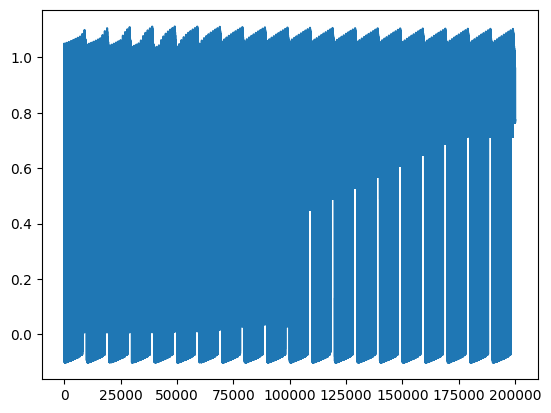

In [4]:
import numpy as np
import matplotlib.pyplot as plt
t_w=50
import os
def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol

def getConstraintFromData(w_i=1, data_folder="./validation/"):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)
    SOLs = np.empty(0)
    SOLw = np.empty(0)
    V = np.empty(0)
    U = np.empty(0)
    krange = [(0.083 + 0.1 * i * 0.05) for i in range(0, 10)]
    vrange = [(0.015 + 0.053 * i * 0.12) for i in range(0, 20)]
    urange = [(0.05 + 0.04 * i * 1) for i in range(0, 20)]


    deltaT = 0.01
    rate = 100
    i=0
    for UR in urange:
        for KR in krange:
            for VR in vrange:
                sol = generateExactSolution(t_w, deltaT, UR, VR, rate, KR, 0, t_w)

                T = np.append(T, sol.T[2] - 0)
                K = np.append(K, np.full_like(sol.T[2], KR))
                U = np.append(U, np.full_like(sol.T[2], UR))
                V = np.append(V, np.full_like(sol.T[2], VR))
                SOLs = np.append(SOLs, sol.T[0])
                SOLw = np.append(SOLw, sol.T[1])
                i=i+1

    print(SOLs)
    plt.plot(SOLs)
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
    
    
getConstraintFromData()


In [3]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

##mostra que ele cria uma cond inicial novamente para cada janela
import vtk
import matplotlib.pyplot as plt
import scipy  

import vtk
from vtk.util.numpy_support import vtk_to_numpy

import vtk
import matplotlib.pyplot as plt
import numpy as np

import vtk
from vtk.util.numpy_support import vtk_to_numpy
t_max=50
t_w=50
def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol

def getConstraintFromData(w_i=1, data_folder="./treino3/"):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)
    SOLs = np.empty(0)
    SOLw = np.empty(0)
    V = np.empty(0)
    U = np.empty(0)

    krange = [(0.08 + 0.1 * i * 0.01) for i in range(1,4)]
    vrange = [(0 + 0.01 * i * 0.12) for i in range(30,70)]
    urange = [(0 + 0.1 * i * 1) for i in range(3,4)]
    deltaT = 0.01
    rate =25
    
    for UR in urange:
        for KR in krange:
            for VR in vrange:
                sol = generateExactSolution(t_w, deltaT, UR, VR, rate, KR, 0, t_w)

                T = np.append(T, sol.T[2] - 0)
                K = np.append(K, np.full_like(sol.T[2], KR))
                U = np.append(U, np.full_like(sol.T[2], UR))
                V = np.append(V, np.full_like(sol.T[2], VR))
                SOLs = np.append(SOLs, sol.T[0])
                SOLw = np.append(SOLw, sol.T[1])

    #print(SOLs)
    plt.plot(SOLs)
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
getConstraintFromData()

SyntaxError: invalid character in identifier (1126308712.py, line 60)